In [1]:
import numpy as np
from scipy import stats
import math
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist
import sys
from haversine import haversine
import pandas as pd
import geopandas as gpd

In [2]:
def custom_dist(u, v):
    if u[2] == v[2]:
        return sys.float_info.max
    else:
        return haversine([u[0], u[1]], [v[0], v[1]])

thresholds = {'CurbRamp': 0.0075,
                      'NoCurbRamp': 0.0075,
                      'SurfaceProblem': 0.01,
                      'Obstacle': 0.01,
                      'NoSidewalk': 0.01,
                      'Crosswalk': 0.01,
                      'Signal': 0.01,
                      'Occlusion': 0.01,
                      'Other': 0.01,
                      'Problem': 0.01}

def cluster(labels, label_type, thresholds):

    # Makes a normal dist matrix for a single user, but uses special dist function for multi-user clustering that
    # prevents the same user's attributes from being clustered together.
    dist_matrix = pdist(np.array(labels[['lat', 'lng', 'user_id']].values), custom_dist)
    link = linkage(dist_matrix, method='complete')
    curr_type = labels['label_type'].values

    # Copies the labels dataframe and adds a column to it for the cluster id each label is in.
    labelsCopy = labels.copy()
    labelsCopy.loc[:,'cluster_id'] = fcluster(link, t=thresholds[label_type], criterion='distance')

    # Cuts tree so that only labels less than clust_threth kilometers apart are clustered.
    clusters = labelsCopy.groupby('cluster_id')

    # Computes the center of each cluster and assigns temporariness and severity.
    cluster_list = [] # list of tuples (label_type, cluster_num, lat, lng, severity, temporary).
    for clust_num, clust in clusters:
        #ave_pos = np.mean(clust['coords'].tolist(), axis=0) # use ave pos of clusters.
        #ave_sev = None if pd.isnull(clust['severity']).all() else int(round(np.median(clust['severity'][~np.isnan(clust['severity'])])))
        #ave_temp = None if pd.isnull(clust['temporary']).all() else bool(round(np.mean(clust['temporary'])))

        cluster_list.append((curr_type, clust_num))

    cluster_df = pd.DataFrame(cluster_list, columns=['label_type', 'cluster_id'])

    return (cluster_df, labelsCopy)


# Pick which label types should be included in clustering, and which should be included in the "Problem" type.
label_types = ['CurbRamp', 'NoSidewalk', 'Occlusion', 'SurfaceProblem', 'Obstacle', 'Other', 'NoCurbRamp', 'Crosswalk', 'Signal']
# problem_types = ['SurfaceProblem', 'Obstacle']

# These are the columns required in the POST requests for the labels and clusters, respectively.
label_cols = ['label_id', 'label_type', 'cluster_id']
cluster_cols = ['label_type', 'cluster_id', 'lat', 'lng', 'severity', 'temporary']


def cluster_label_type_at_index(label_data,i):
        clusters_for_type_i = pd.DataFrame(columns=cluster_cols)
        labels_for_type_i = pd.DataFrame(columns=label_cols)

        label_type = label_types[i]
        # if label_type == 'Problem':
        #     type_data = label_data[label_data.label_type.isin(problem_types)]
        # else:
        type_data = label_data[label_data.label_type == label_type]

        # If there are >1 labels, we can do clustering. Otherwise just copy the 1 (or 0) labels.
        if type_data.shape[0] > 1:
            (clusters_for_type_i, labels_for_type_i) = cluster(type_data, label_type, thresholds)
        elif type_data.shape[0] == 1:
            labels_for_type_i = type_data.copy()
            labels_for_type_i.loc[:,'cluster_id'] = 1 # Gives the single cluster a cluster_id of 1.
            labels_for_type_i.loc[:,'label_type'] = label_type # Gives Problem type if needed.
            clusters_for_type_i = labels_for_type_i.filter(items=cluster_cols)

        return (label_type, clusters_for_type_i, labels_for_type_i)

In [4]:
df = gpd.read_file('data/processed-labels/labels_all_oradell/labels_all_oradell.shp')

In [5]:
df

,audit_task,label_id,gsv_panora,label_type,severity,correct,high_quali,gsv_pano_1,zoom,heading,pitch,photograph,photogra_1,user_id,lat,lng,geometry
0,7,9,8AsY4nlOJQAo8P5YYaEjzA,CurbRamp,1.0,1,1,8AsY4nlOJQAo8P5YYaEjzA,2,309.035706,-15.723214,108.536644,-0.496017,503d2482-420f-454e-8118-aac2d22592aa,40.945518,-74.034111,POINT (-74.03411 40.94552)
1,7,10,8AsY4nlOJQAo8P5YYaEjzA,NoSidewalk,5.0,1,1,8AsY4nlOJQAo8P5YYaEjzA,2,303.232147,-13.580358,108.536644,-0.496017,503d2482-420f-454e-8118-aac2d22592aa,40.945541,-74.034142,POINT (-74.03414 40.94554)
2,7,11,8AsY4nlOJQAo8P5YYaEjzA,CurbRamp,1.0,1,1,8AsY4nlOJQAo8P5YYaEjzA,2,266.714294,-12.330358,108.536644,-0.496017,503d2482-420f-454e-8118-aac2d22592aa,40.945435,-74.034157,POINT (-74.03416 40.94543)
3,7,12,8AsY4nlOJQAo8P5YYaEjzA,NoSidewalk,5.0,1,1,8AsY4nlOJQAo8P5YYaEjzA,2,270.821442,-11.616072,108.536644,-0.496017,503d2482-420f-454e-8118-aac2d22592aa,40.945446,-74.034203,POINT (-74.03420 40.94545)
4,7,13,8AsY4nlOJQAo8P5YYaEjzA,Crosswalk,1.0,1,1,8AsY4nlOJQAo8P5YYaEjzA,2,284.392853,-13.758928,108.536644,-0.496017,503d2482-420f-454e-8118-aac2d22592aa,40.945473,-74.034142,POINT (-74.03414 40.94547)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12129,2194,13096,28tGbhCsMyFUsKRs7-jp_A,NoCurbRamp,2.0,1,1,28tGbhCsMyFUsKRs7-jp_A,2,189.401779,-10.892858,287.290100,-2.176155,528eb1d6-e20e-4fb9-81c9-0c06b9e2852f,40.954376,-74.030624,POINT (-74.03062 40.95438)
12130,2194,13097,28tGbhCsMyFUsKRs7-jp_A,Obstacle,4.0,None,1,28tGbhCsMyFUsKRs7-jp_A,2,189.401779,-10.892858,287.290100,-2.176155,528eb1d6-e20e-4fb9-81c9-0c06b9e2852f,40.954391,-74.030617,POINT (-74.03062 40.95439)
12131,2194,13098,5zDLTjYdw6hQhfsXppE0cA,SurfaceProblem,1.0,1,1,5zDLTjYdw6hQhfsXppE0cA,2,77.437500,-23.928572,287.278870,-2.803400,528eb1d6-e20e-4fb9-81c9-0c06b9e2852f,40.954624,-74.030891,POINT (-74.03089 40.95462)
12132,2202,13099,WkdNrR64GZUC1V_at1pxyA,NoCurbRamp,NaN,None,0,WkdNrR64GZUC1V_at1pxyA,1,178.687500,-8.625000,281.559601,-2.859410,0cfe6980-35ac-4cdd-a2df-cbee02531406,40.969189,-74.029976,POINT (-74.02998 40.96919)


In [6]:
df0 = cluster_label_type_at_index(df,0)[2]

In [7]:
df1 = cluster_label_type_at_index(df,1)[2]

In [8]:
df2 = cluster_label_type_at_index(df,2)[2]

In [9]:
df3 = cluster_label_type_at_index(df,3)[2]

In [10]:
df4 = cluster_label_type_at_index(df,4)[2]

In [11]:
df5 = cluster_label_type_at_index(df,5)[2]

In [12]:
df6 = cluster_label_type_at_index(df,6)[2]

In [13]:
df7 = cluster_label_type_at_index(df,7)[2]

In [14]:
df8 = cluster_label_type_at_index(df,8)[2]

In [15]:
df0["clustered"] = df0.duplicated(subset="cluster_id", keep=False)
df1["clustered"] = df1.duplicated(subset="cluster_id", keep=False)
df2["clustered"] = df2.duplicated(subset="cluster_id", keep=False)
df3["clustered"] = df3.duplicated(subset="cluster_id", keep=False)
df4["clustered"] = df4.duplicated(subset="cluster_id", keep=False)
df5["clustered"] = df5.duplicated(subset="cluster_id", keep=False)
df6["clustered"] = df6.duplicated(subset="cluster_id", keep=False)
df7["clustered"] = df7.duplicated(subset="cluster_id", keep=False)
df8["clustered"] = df8.duplicated(subset="cluster_id", keep=False)

In [16]:
df0

,audit_task,label_id,gsv_panora,label_type,severity,correct,high_quali,gsv_pano_1,zoom,heading,pitch,photograph,photogra_1,user_id,lat,lng,geometry,cluster_id,clustered
0,7,9,8AsY4nlOJQAo8P5YYaEjzA,CurbRamp,1.0,1,1,8AsY4nlOJQAo8P5YYaEjzA,2,309.035706,-15.723214,108.536644,-0.496017,503d2482-420f-454e-8118-aac2d22592aa,40.945518,-74.034111,POINT (-74.03411 40.94552),442,True
2,7,11,8AsY4nlOJQAo8P5YYaEjzA,CurbRamp,1.0,1,1,8AsY4nlOJQAo8P5YYaEjzA,2,266.714294,-12.330358,108.536644,-0.496017,503d2482-420f-454e-8118-aac2d22592aa,40.945435,-74.034157,POINT (-74.03416 40.94543),467,True
5,7,14,8AsY4nlOJQAo8P5YYaEjzA,CurbRamp,1.0,1,1,8AsY4nlOJQAo8P5YYaEjzA,1,45.428570,-33.785713,108.536644,-0.496017,503d2482-420f-454e-8118-aac2d22592aa,40.945480,-74.033981,POINT (-74.03398 40.94548),422,True
6,7,15,8AsY4nlOJQAo8P5YYaEjzA,CurbRamp,1.0,1,1,8AsY4nlOJQAo8P5YYaEjzA,1,151.178574,-35.000000,108.536644,-0.496017,503d2482-420f-454e-8118-aac2d22592aa,40.945415,-74.034012,POINT (-74.03401 40.94542),471,True
18,7,27,7pDHlqVEtaIL-DbjuR-Bwg,CurbRamp,1.0,1,1,7pDHlqVEtaIL-DbjuR-Bwg,1,289.680267,-35.000000,198.439819,-0.389183,503d2482-420f-454e-8118-aac2d22592aa,40.945045,-74.034348,POINT (-74.03435 40.94505),301,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12122,2194,13089,Vt97GiZnUV_5dfj6ZRhBvA,CurbRamp,3.0,None,1,Vt97GiZnUV_5dfj6ZRhBvA,2,36.544643,-35.000000,287.855011,-3.234470,528eb1d6-e20e-4fb9-81c9-0c06b9e2852f,40.954491,-74.030472,POINT (-74.03047 40.95449),13,True
12123,2194,13090,Vt97GiZnUV_5dfj6ZRhBvA,CurbRamp,2.0,1,1,Vt97GiZnUV_5dfj6ZRhBvA,2,346.633942,-28.928572,287.855011,-3.234470,528eb1d6-e20e-4fb9-81c9-0c06b9e2852f,40.954521,-74.030479,POINT (-74.03048 40.95452),11,True
12125,2194,13092,Vt97GiZnUV_5dfj6ZRhBvA,CurbRamp,2.0,None,1,Vt97GiZnUV_5dfj6ZRhBvA,2,313.330353,-17.410715,287.855011,-3.234470,528eb1d6-e20e-4fb9-81c9-0c06b9e2852f,40.954571,-74.030602,POINT (-74.03060 40.95457),7,True
12126,2194,13093,28tGbhCsMyFUsKRs7-jp_A,CurbRamp,2.0,1,1,28tGbhCsMyFUsKRs7-jp_A,2,358.151794,-35.000000,287.290100,-2.176155,528eb1d6-e20e-4fb9-81c9-0c06b9e2852f,40.954521,-74.030594,POINT (-74.03059 40.95452),4,True


In [17]:
#concatenate all dataframes
clusters = pd.concat([df0, df1, df2, df3, df4, df5, df6, df7, df8])

In [18]:
clusters

,audit_task,label_id,gsv_panora,label_type,severity,correct,high_quali,gsv_pano_1,zoom,heading,pitch,photograph,photogra_1,user_id,lat,lng,geometry,cluster_id,clustered
0,7,9,8AsY4nlOJQAo8P5YYaEjzA,CurbRamp,1.0,1,1,8AsY4nlOJQAo8P5YYaEjzA,2,309.035706,-15.723214,108.536644,-0.496017,503d2482-420f-454e-8118-aac2d22592aa,40.945518,-74.034111,POINT (-74.03411 40.94552),442,True
2,7,11,8AsY4nlOJQAo8P5YYaEjzA,CurbRamp,1.0,1,1,8AsY4nlOJQAo8P5YYaEjzA,2,266.714294,-12.330358,108.536644,-0.496017,503d2482-420f-454e-8118-aac2d22592aa,40.945435,-74.034157,POINT (-74.03416 40.94543),467,True
5,7,14,8AsY4nlOJQAo8P5YYaEjzA,CurbRamp,1.0,1,1,8AsY4nlOJQAo8P5YYaEjzA,1,45.428570,-33.785713,108.536644,-0.496017,503d2482-420f-454e-8118-aac2d22592aa,40.945480,-74.033981,POINT (-74.03398 40.94548),422,True
6,7,15,8AsY4nlOJQAo8P5YYaEjzA,CurbRamp,1.0,1,1,8AsY4nlOJQAo8P5YYaEjzA,1,151.178574,-35.000000,108.536644,-0.496017,503d2482-420f-454e-8118-aac2d22592aa,40.945415,-74.034012,POINT (-74.03401 40.94542),471,True
18,7,27,7pDHlqVEtaIL-DbjuR-Bwg,CurbRamp,1.0,1,1,7pDHlqVEtaIL-DbjuR-Bwg,1,289.680267,-35.000000,198.439819,-0.389183,503d2482-420f-454e-8118-aac2d22592aa,40.945045,-74.034348,POINT (-74.03435 40.94505),301,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2647,555,2834,W79gjq0NEiDVNJsSks8byQ,Signal,NaN,0,1,W79gjq0NEiDVNJsSks8byQ,1,35.042412,-20.562500,7.179101,1.035385,4c7fbac9-74c0-4c5b-8695-0d14b4a98fe4,40.951401,-74.031944,POINT (-74.03194 40.95140),2,False
3096,659,3439,GegGge2J10ZzaNZyr9mNsg,Signal,NaN,0,1,GegGge2J10ZzaNZyr9mNsg,2,305.104370,-4.910714,290.225952,0.064026,28dde253-b030-4572-a70e-589d04c564d8,40.961285,-74.034149,POINT (-74.03415 40.96128),3,False
11968,1865,12721,gG1Gkhv0cbsZ_ed2e9HKwQ,Signal,NaN,None,1,gG1Gkhv0cbsZ_ed2e9HKwQ,1,126.312500,-6.250000,108.298988,2.712456,1789fa8b-778f-48d7-a7f7-95259105e361,40.954430,-74.049728,POINT (-74.04973 40.95443),6,False
11969,1865,12722,gG1Gkhv0cbsZ_ed2e9HKwQ,Signal,NaN,None,1,gG1Gkhv0cbsZ_ed2e9HKwQ,1,102.125000,-6.625000,108.298988,2.712456,1789fa8b-778f-48d7-a7f7-95259105e361,40.954632,-74.049675,POINT (-74.04967 40.95463),8,False


<AxesSubplot: >

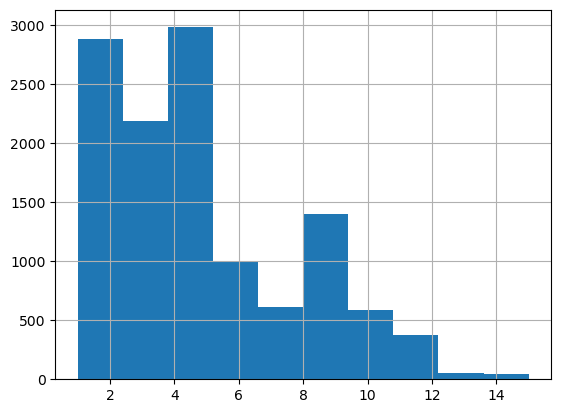

In [20]:
#count the number of same cluser_ids and store in a column
clusters['count'] = clusters.groupby('cluster_id')['cluster_id'].transform('count')
#count in histogram
clusters['count'].hist()

In [21]:
#select only label_id cluster_id and count
clusters = clusters[['label_id', 'cluster_id', 'count']]
clusters

,label_id,cluster_id,count
0,9,442,5
2,11,467,5
5,14,422,5
6,15,471,6
18,27,301,9
...,...,...,...
2647,2834,2,11
3096,3439,3,12
11968,12721,6,9
11969,12722,8,9


In [22]:
#make new folder features
!mkdir data/features

In [23]:
#export to shapefile
clusters.to_csv('data/features/clustered.csv', index=False)